# Monte Carlo Methods

Dynamic programming is a model-based method and it requires the model dynamics of the environment to compute the value and Q functions in order to find the
optimal policy.
Model-free methods do not require the model dynamics of the environment to compute the value and Q functions in order to find the optimal policy. One such popular model-free method is the ***Monte Carlo*** (MC) method.

Monte Carlo methods are ways of solving the reinforcement learning problem based on averaging sample returns. To ensure that well-defined returns are available, here we define Monte Carlo methods only for episodic tasks.

# Prediction and control tasks

In reinforcement learning, we perform two important tasks:
+ Prediction tasks
+ Control tasks

## Prediction task

In the prediction task, a policy $\pi$ is given as an input and we try to predict the value function or Q function using the given policy. Our goal is to evaluate the given policy. we can evaluate the given policy $\pi$ by computing the value and Q functions.

## Control task

Unlike the prediction task, in the control task, we will not be given any policy as an input. In the control task, our goal is to find the optimal policy. So, we will start off by initializing a random policy and we try to find the optimal policy iteratively.

# Monte Carlo prediction

Suppose we wish to estimate $v_\pi(s)$, the value of a state $s$ under policy $\pi$, given a set of episodes obtained by following $\pi$ and passing through $s$. Each occurrence of state $s$ in an episode is called a visit to $s$.

Of course, $s$ may be visited multiple times in the same episode; let us call the first time it is visited in an episode the first visit to $s$. The *first-visit* MC method estimates $v_\pi(s)$ as the average of the returns following first visits to $s$, whereas the *every-visit* MC method averages the returns following all visits to $s$.

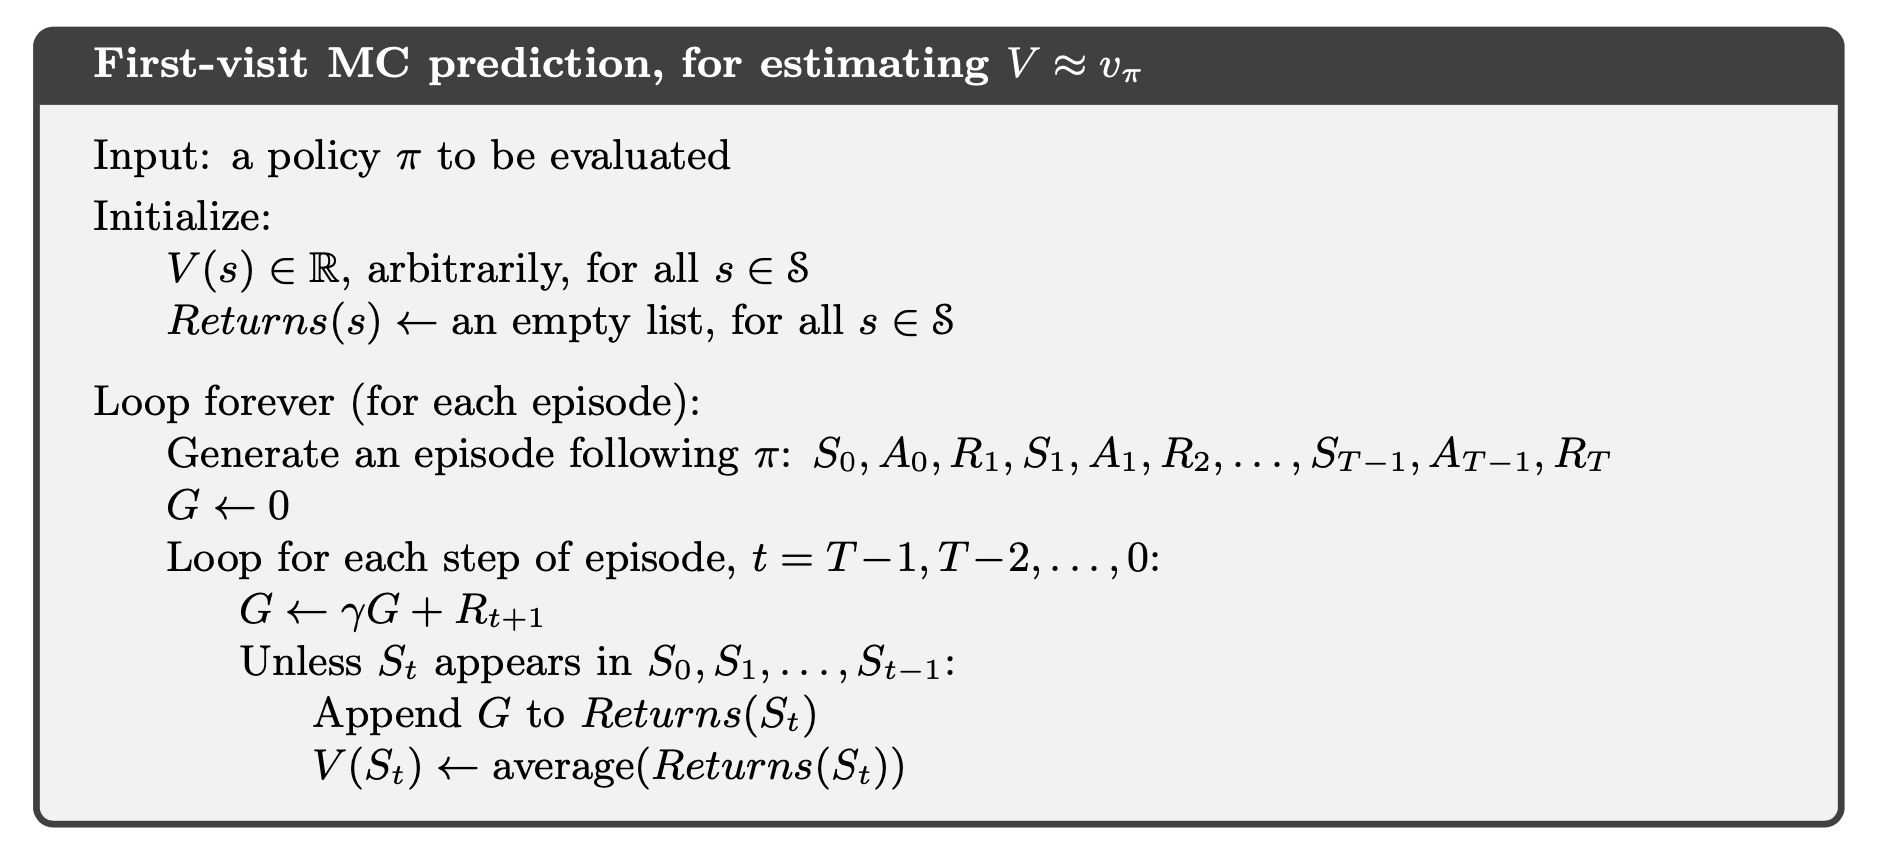

<img src='https://i.stack.imgur.com/Q8YCg.png' width='60%' />

DP methods require the distribution of next events, in particular, they require the environments dynamics as given by the four-argument function $p$. All of the probabilities must be computed before DP can be applied, and such computations are often complex and error-prone. In contrast, generating the sample games required by Monte Carlo methods is easy. This is the case surprisingly often; the ability of Monte Carlo methods to work with sample episodes alone can be a significant advantage even when one has complete knowledge of the environment’s dynamics.

## Example: Blackjack

In [18]:
import gym
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
print(env.reset())

(17, 10, False)


In [4]:
print(env.action_space)

Discrete(2)


The reward will be assigned as follows:
+ +1.0 reward if we win the game
+ -1.0 reward if we lose the game
+ 0 reward if the game is a draw

In [5]:
def policy(state):
    return 0 if state[0] > 19 else 1

In [6]:
episode_limit = 100
def generate_episode(policy):
    episodes = []
    state = env.reset()
    for i in range(episode_limit):
        action = policy(state)
        next_state, reward, done, info = env.step(action)
        episodes.append((state, action, reward))
        if done:
            break
        state = next_state
    return episodes

In [7]:
generate_episode(policy)

[((5, 10, False), 1, 0.0),
 ((16, 10, True), 1, 0.0),
 ((16, 10, False), 1, 0.0),
 ((17, 10, False), 1, -1.0)]

In [8]:
def first_visit_MC(gamma=1, iterations=500000):
    returns = defaultdict(float)
    N = defaultdict(int)
    
    for i in tqdm(range(iterations)):
        episodes = generate_episode(policy)
        states = [e[0] for e in episodes]
        G = 0.0
        for t in reversed(range(len(episodes))):
            state, action, reward = episodes[t]
            G = gamma * G + reward
            if state not in states[:t]:
                returns[state] = returns[state] + G
                N[state] = N[state] + 1
        
    return returns, N

In [9]:
def every_visit_MC(gamma=1, iterations=500000):
    returns = defaultdict(float)
    N = defaultdict(int)
    
    for i in tqdm(range(iterations)):
        episodes = generate_episode(policy)
        G = 0.0
        for t in reversed(range(len(episodes))):
            state, action, reward = episodes[t]
            G = gamma * G + reward
            returns[state] = returns[state] + G
            N[state] = N[state] + 1
        
    return returns, N

In [10]:
returns, N = first_visit_MC()

100%|██████████| 500000/500000 [00:51<00:00, 9752.61it/s] 


In [11]:
df_returns = pd.DataFrame(returns.items(),columns=['state','return'])
df_returns

,state,return
0,"(20, 3, False)",4812.0
1,"(12, 3, False)",-2563.0
2,"(11, 3, False)",-141.0
3,"(21, 7, True)",2143.0
4,"(19, 1, False)",-4394.0
...,...,...
275,"(5, 1, False)",-263.0
276,"(12, 8, True)",-47.0
277,"(4, 6, False)",-103.0
278,"(4, 3, False)",-110.0


In [12]:
df_N = pd.DataFrame(N.items(),columns=['state','N'])
df_N

,state,N
0,"(20, 3, False)",7325
1,"(12, 3, False)",4593
2,"(11, 3, False)",2175
3,"(21, 7, True)",2344
4,"(19, 1, False)",5580
...,...,...
275,"(5, 1, False)",446
276,"(12, 8, True)",236
277,"(4, 6, False)",210
278,"(4, 3, False)",232


In [13]:
df = pd.merge(df_N, df_returns, on="state")
df['value'] = df['return'] / df['N']
df[df['state'] == (7,10,False)]

,state,N,return,value
20,"(7, 10, False)",3819,-2177.0,-0.570045


# Monte Carlo Control

The overall idea is to proceed according to the idea of generalized policy iteration (GPI). In GPI one maintains both an approximate policy and an approximate value function.
The value function is repeatedly altered to more closely approximate the value function for the current policy, and the policy is repeatedly improved with respect to the current value function.

In this method, we perform alternating complete steps of policy evaluation and policy improvement, beginning with an arbitrary policy $\pi_0$ and ending with the optimal policy and optimal action-value function:
$$ \pi_0 \xrightarrow[]{E} q_{\pi_0} \xrightarrow[]{I} \pi_1 \xrightarrow[]{E} q_{\pi_1} \xrightarrow[]{I} \pi_2 \xrightarrow[]{E} \dots  \xrightarrow[]{I} \pi^* \xrightarrow[]{E} q_{\pi^*} $$
where $\xrightarrow[]{E}$ denotes a complete policy evaluation and $\xrightarrow[]{I}$ denotes a complete policy improvement.

We made two unlikely assumptions above in order to easily obtain this guarantee of convergence for the Monte Carlo method. One was that the episodes have exploring starts, and the other was that policy evaluation could be done with an infinite number of episodes.

We can classify the control methods into two types:
+ **On-policy control** - In the on-policy control method, the agent behaves using one policy and also tries to improve the same policy. That is, in the on-policy method, we generate episodes using one policy and also improve the same policy iteratively to find the optimal policy. 
+ **Off-policy control** - In the off-policy control method, the agent behaves using one policy $b$ and tries to improve a different policy $\pi$. That is, in the off-policy method, we generate episodes using one policy and we try to improve the different policy iteratively to find the optimal policy.

# On-policy Monte Carlo control

There are two types of on-policy Monte Carlo control methods:
+ Monte Carlo exploring starts
+ Monte Carlo with the epsilon-greedy policy

## Monte Carlo exploring starts

For Monte Carlo policy iteration it is natural to alternate between evaluation and improvement on an episode-by-episode basis. After each episode, the observed returns are used for policy evaluation, and then the policy is improved at all the states visited in the episode. A complete simple algorithm along these lines, which we call **Monte Carlo with Exploring Starts**.

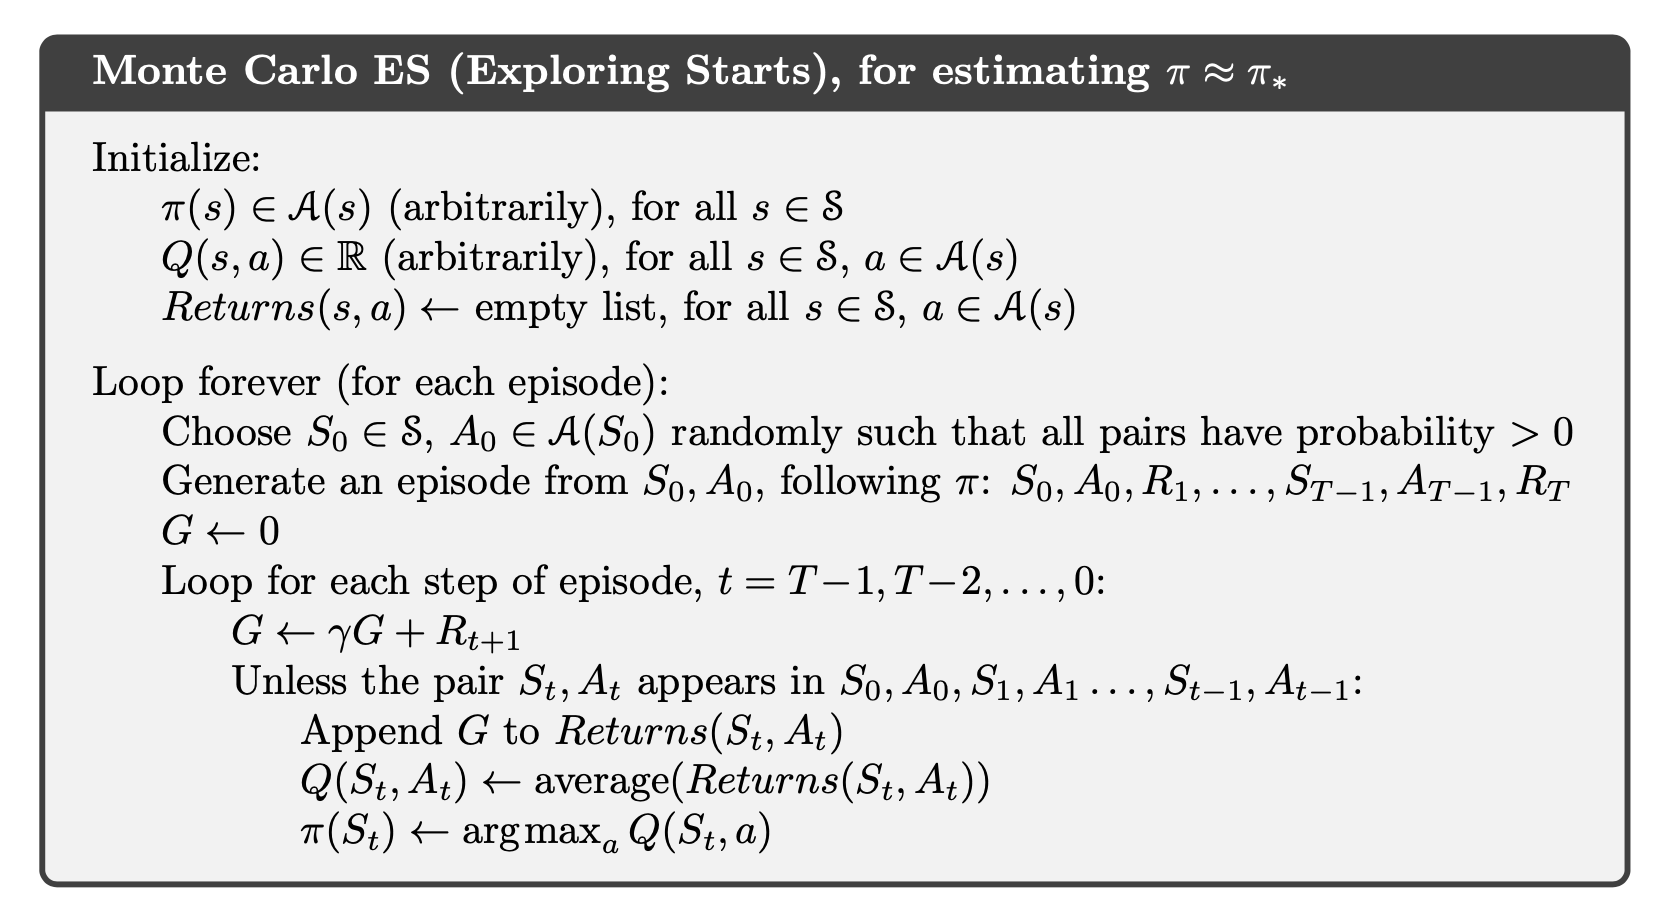

In Monte Carlo ES, all the returns for each state–action pair are accumulated and averaged, irrespective of what policy was in force when they were observed. It is easy to see that Monte Carlo ES cannot converge to any suboptimal policy.

## Monte Carlo with the epsilon-greedy policy

The overall idea of on-policy Monte Carlo control is still that of GPI. As in Monte Carlo ES, we use first-visit MC methods to estimate the action-value function for the current policy. As we can observe, in every iteration, we generate the episode using the policy $\pi$ and also we try to improve the same policy $\pi$ in every iteration to compute the optimal policy.

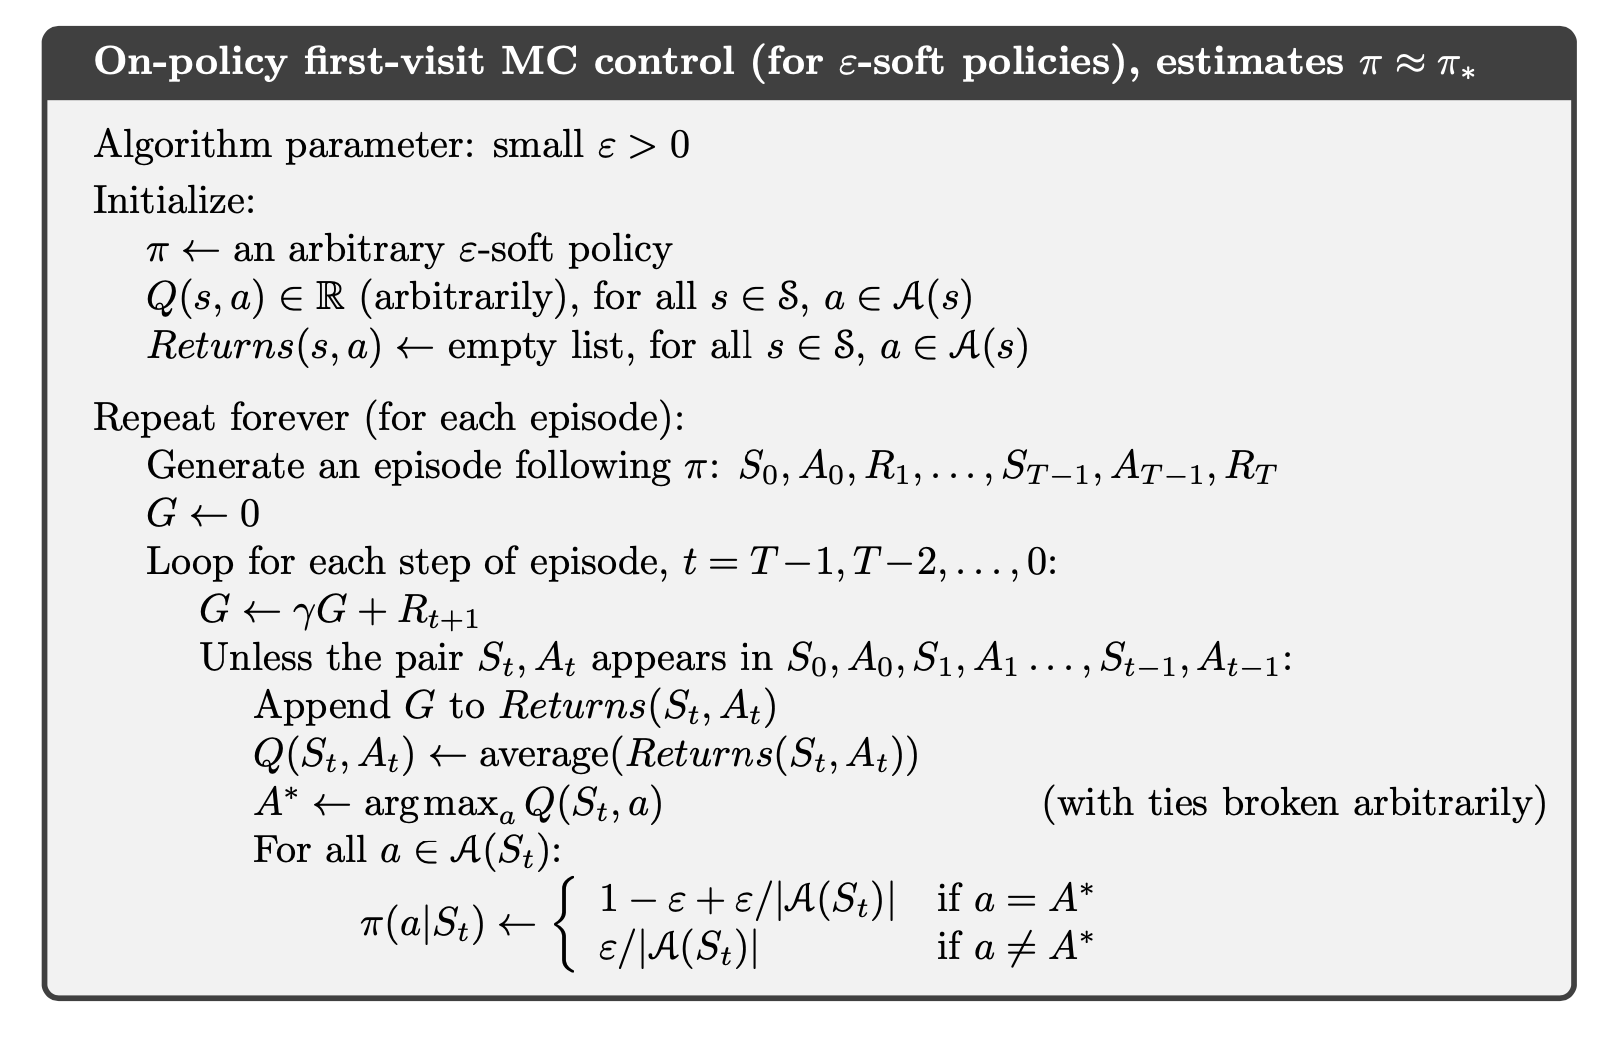

# Implementing MC control with the epsilon-greedy policy

In [14]:
def epsilon_greedy_policy(pi, state, epsilon=.5):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax([ pi[(state,0)], pi[(state,1)] ])

In [15]:
episode_limit = 100
def generate_episode_pi(pi):
    episodes = []
    state = env.reset()
    for i in range(episode_limit):
        action = epsilon_greedy_policy(pi, state)
        next_state, reward, done, info = env.step(action)
        episodes.append((state, action, reward))
        if done:
            break
        state = next_state
    return episodes

In [30]:
def first_visit_MC_control(gamma=1, iterations=500000, epsilon=.5):
    pi = defaultdict(float)
    Q = defaultdict(float)
    returns = defaultdict(list)
    
    for i in tqdm(range(iterations)):
        episodes = generate_episode_pi(pi)
        state_action = [e[0:2] for e in episodes]
        G = 0.0
        for t in reversed(range(len(episodes))):
            state, action, reward = episodes[t]
            G = gamma * G + reward
            if (state, action) not in state_action[:t]:
                returns[(state,action)].append(G)
                Q[(state,action)] = np.mean(returns[(state,action)])
                As = np.argmax([ Q[(state,0)], Q[(state,1)] ])
                for a in [0,1]:
                    if As == a:
                        pi[(state, a)] = 1 - epsilon / 2
                    else:
                        pi[(state, a)] = epsilon / 2

    return Q, pi

In [19]:
Q, pi = first_visit_MC_control()

100%|██████████| 500000/500000 [03:52<00:00, 2147.35it/s]


In [23]:
df = pd.DataFrame(Q.items(),columns=['state_action','q-value'])
df

,state_action,q-value
0,"((20, 2, False), 0)",0.659135
1,"((20, 2, False), 1)",-0.902634
2,"((12, 8, False), 0)",-0.491371
3,"((12, 8, False), 1)",-0.418256
4,"((12, 1, False), 0)",-0.755140
...,...,...
555,"((4, 2, False), 0)",-0.176471
556,"((12, 4, True), 0)",-0.357143
557,"((12, 4, True), 1)",0.052023
558,"((12, 6, True), 0)",-0.156250


In [31]:
df[(df['state_action'] == ((21,8, True),0)) | (df['state_action'] == ((21,8, True),1))]

,state_action,q-value
242,"((21, 8, True), 0)",0.930292
243,"((21, 8, True), 1)",0.000000


# Off-policy Monte Carlo Prediction

All learning control methods face a dilemma: They seek to learn action values conditional on subsequent optimal behavior, but they need to behave non-optimally in order to explore all actions (to find the optimal actions).

In order to use episodes from $b$ to estimate values for $\pi$, we require that every action taken under $\pi$ is also taken, at least occasionally, under $b$. That is, we require that $\pi(a|s) > 0$ implies $b(a|s) > 0$. This is called the assumption of coverage. It follows from coverage that b must be stochastic in states where it is not identical to $\pi$.

A straightforward approach is to use two policies, one that is learned about and that becomes the optimal policy, and one that is more exploratory and is used to generate behavior. The policy being learned about is called the ***target policy***, and the policy used to generate behavior is called the ***behavior policy***. In this case we say that learning is from data _“off”_ the target policy, and the overall process is termed ***off-policy learning***.

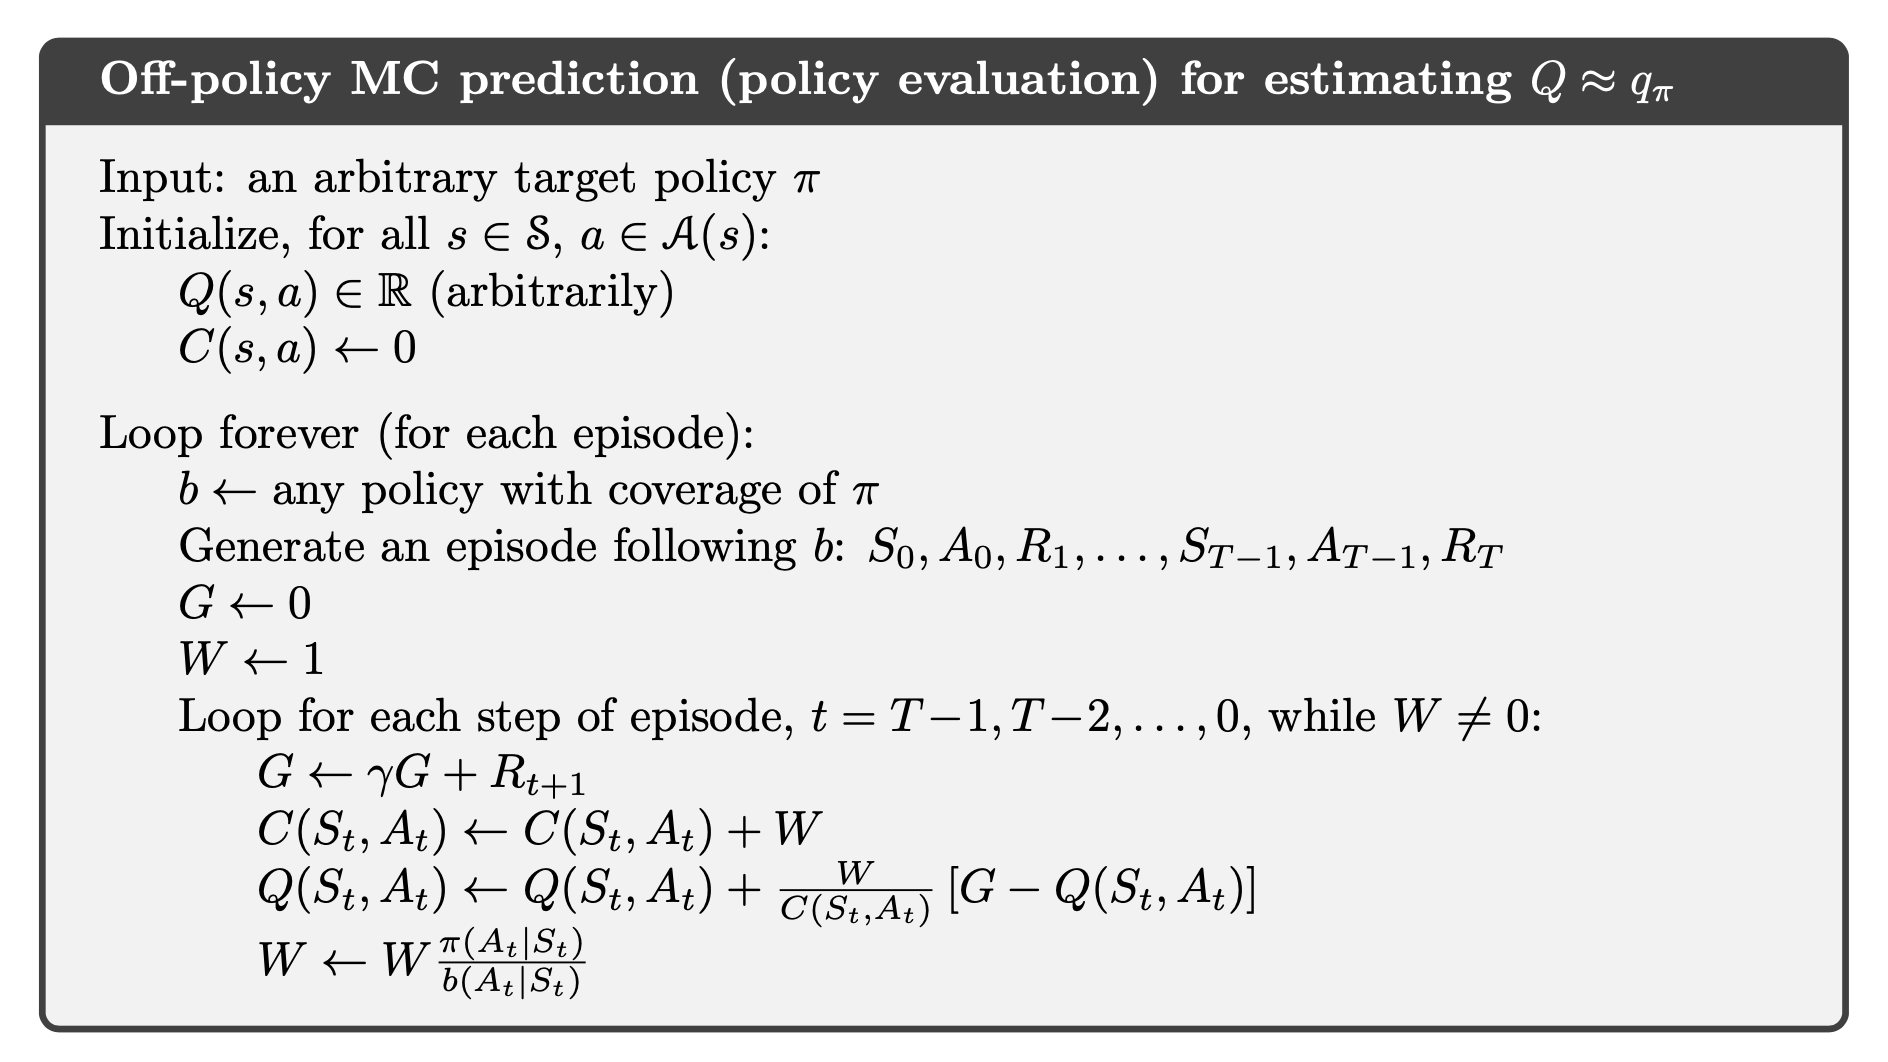

# Off-policy Monte Carlo control

The policy used to generate behavior, called the behavior policy, may in fact be unrelated to the policy that is evaluated and improved, called the target policy. An advantage of this separation is that the target policy may be deterministic (e.g., greedy), while the behavior policy can continue to sample all possible actions.

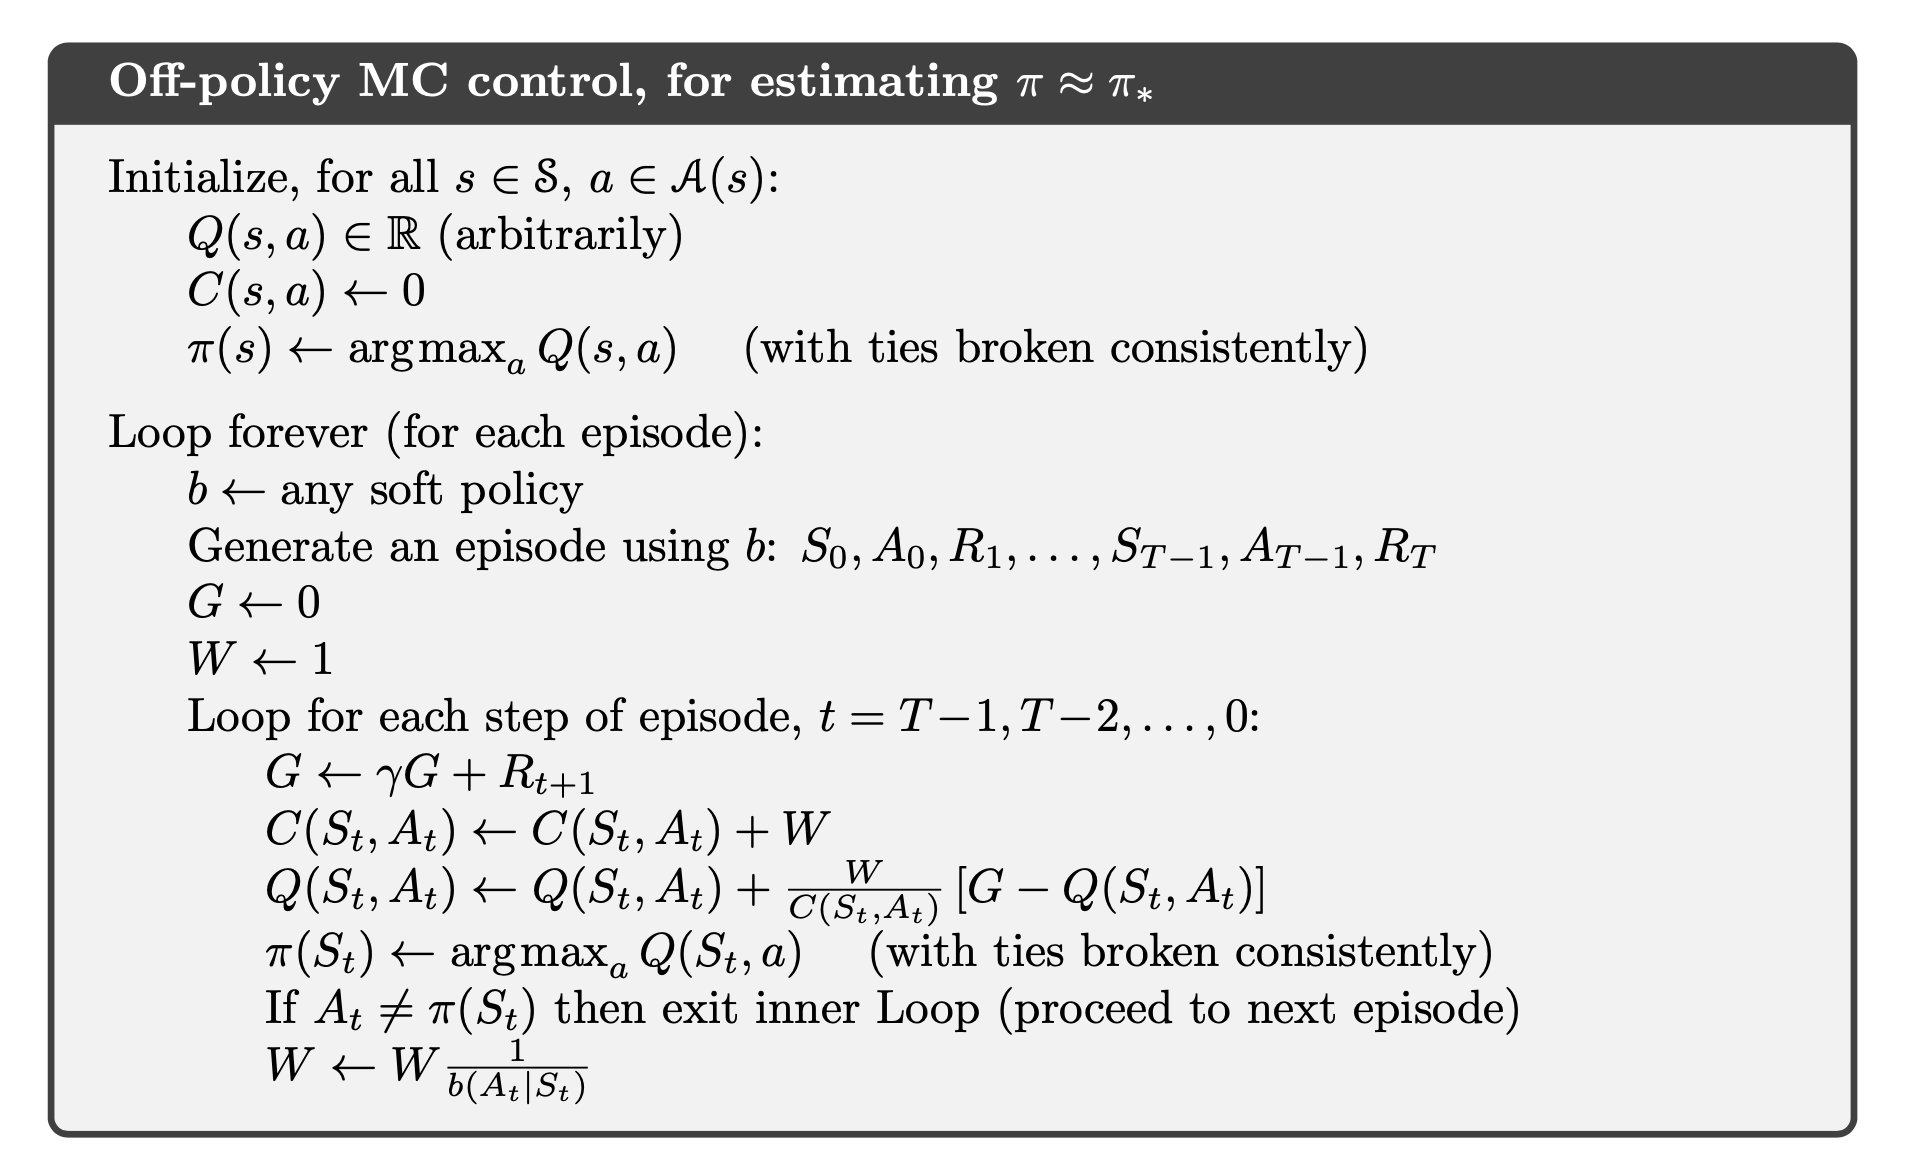